In [7]:
import pandas as pd

# using the kaggle csv
df = pd.read_csv('music_feats.csv')

df.head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [19]:
x_feat_list = df.columns[1:-1]

x = df.loc[:, x_feat_list].values
y = df.loc[:, 'label'].values

y_feat_list = np.unique(y)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'blues'),
  Text(1, 0, 'classical'),
  Text(2, 0, 'country'),
  Text(3, 0, 'disco'),
  Text(4, 0, 'hiphop'),
  Text(5, 0, 'jazz'),
  Text(6, 0, 'metal'),
  Text(7, 0, 'pop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'rock')])

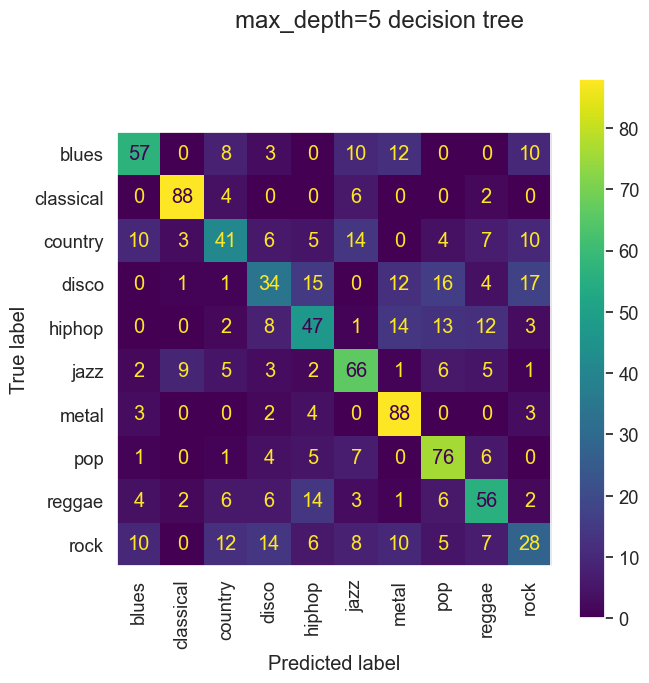

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt

n_splits = 10
max_depth = 5

# initialize k fold
skfold = StratifiedKFold(n_splits=n_splits)

# initialize random forest
dec_tree_clf = RandomForestClassifier(max_depth=max_depth)

# initialize y_pred, stores predictions of y
y_pred = np.empty_like(y)

for train_idx, test_idx in skfold.split(x, y):
    # get training data
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    # get test data    
    x_test = x[test_idx, :]
    
    # fit data
    dec_tree_clf = dec_tree_clf.fit(x_train, y_train)
    
    # estimate on test data
    y_pred[test_idx] = dec_tree_clf.predict(x_test)
    

# build and plot confusion matrix
sns.set(font_scale=1.2)
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=y_feat_list)
conf_mat_disp.plot()
plt.gcf().set_size_inches(7, 7)
plt.grid(False)
plt.suptitle('max_depth=5 decision tree')
plt.xticks(rotation=90)

In [28]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')

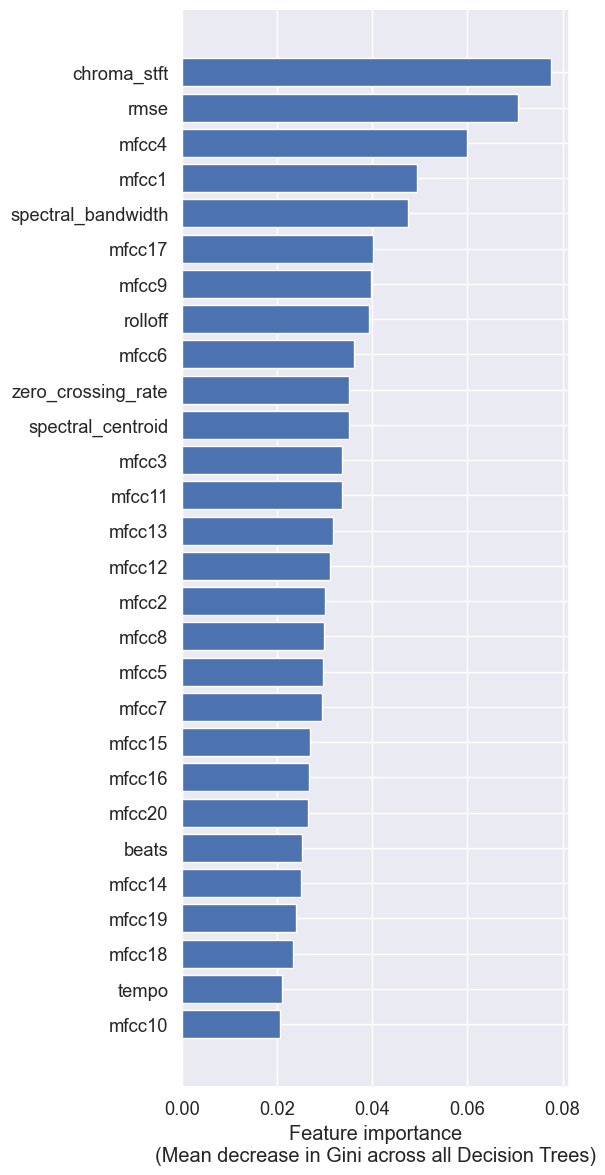

In [29]:
sns.set(font_scale=1.2)

# number of decision trees in the forest
n_estimators = 100
rf_clf = RandomForestClassifier(n_estimators=n_estimators)

# fit random forest to data
rf_clf.fit(x, y)

plot_feat_import(x_feat_list, rf_clf.feature_importances_)